In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = filter INFO, 2 = filter INFO & WARNING, 3 = only ERROR
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0"
#os.environ["XLA_FLAGS"] = "--xla_dump_to=/tmp/xla_logs --xla_dump_hlo_pass=0"
import logging
class XlaFilter(logging.Filter):
    def filter(self, record):
        return "external/local_xla/xla/service/slow_operation_alarm.cc" not in record.msg
logging.getLogger().addFilter(XlaFilter())

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
import json
import math
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

sns.set_theme(style='white', palette=None)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [5]:
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
import keras
from sklearn.utils.class_weight import compute_class_weight
import h5py
from tensorflow.keras import backend as K
import gc
from keras.callbacks import LearningRateScheduler

In [6]:
def get_total_song_count(h5_file_path):
    """Return the list of all song names in the HDF5 file."""
    with h5py.File(h5_file_path, "r") as f:
        return list(f.keys())

In [7]:
def get_total_song_count(h5_file_path):
    """Return the list of all song names in the HDF5 file."""
    with h5py.File(h5_file_path, "r") as f:
        return list(f.keys())

class SongSegmentsGenerator:
    def __init__(self, h5_file_path, song_list, batch_size=16, shuffle=True, random_seed=42):
        self.h5_file_path = h5_file_path
        self.song_list = song_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_seed = random_seed

    def __iter__(self):
        with h5py.File(self.h5_file_path, "r") as f:
            songs = self.song_list.copy()
            if self.shuffle:
                np.random.seed(self.random_seed)
                np.random.shuffle(songs)
            X_batch, y_batch = [], []
            for song in songs:
                grp = f[song]
                target = grp["target"][:]
                seg_keys = list(grp["segments"].keys())
                for seg_key in seg_keys:
                    seg = grp["segments"][seg_key][:]
                    seg = np.expand_dims(seg, axis=-1)
                    X_batch.append(seg)
                    y_batch.append(target)
                    if len(X_batch) == self.batch_size:
                        yield (np.array(X_batch, dtype=np.float32),
                               np.array(y_batch, dtype=np.float32))
                        X_batch, y_batch = [], []
            if len(X_batch) > 0:
                yield (np.array(X_batch, dtype=np.float32),
                       np.array(y_batch, dtype=np.float32))

def create_tf_dataset_from_h5(h5_file_path, song_list, batch_size=16, shuffle=True, random_seed=42):
    output_signature = (
        tf.TensorSpec(shape=(None, 128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 8), dtype=tf.float32)
    )
    generator = SongSegmentsGenerator(
        h5_file_path=h5_file_path,
        song_list=song_list,
        batch_size=batch_size,
        shuffle=shuffle,
        random_seed=random_seed
    )
    ds = tf.data.Dataset.from_generator(lambda: iter(generator), output_signature=output_signature)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def count_batches_in_epoch(h5_file_path, song_list, batch_size):
    total_segments = 0
    with h5py.File(h5_file_path, "r") as f:
        for song in song_list:
            num_seg = len(list(f[song]["segments"].keys()))
            total_segments += num_seg
    return math.ceil(total_segments / batch_size)

In [8]:
h5_file_path = "creating_spectrogram_batches/final_data/data.h5"

In [9]:
# Select songs
all_songs = get_total_song_count(h5_file_path)
total_songs = len(all_songs)
print("Total songs in HDF5 file:", total_songs)

Total songs in HDF5 file: 1025


In [10]:
np.random.seed(42)
np.random.shuffle(all_songs)
num_train = round(total_songs * 0.8)  # 103
train_songs = all_songs[:num_train]
test_songs = all_songs[num_train:]
print("Number of training songs:", len(train_songs))
print("Number of testing songs:", len(test_songs))

# Calculate steps
batch_size = 16 # batch size 32 causes ram issues
steps_per_epoch = count_batches_in_epoch(h5_file_path, train_songs, batch_size)
validation_steps = count_batches_in_epoch(h5_file_path, test_songs, batch_size)
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

# Create datasets
train_ds = create_tf_dataset_from_h5(h5_file_path, song_list=train_songs, batch_size=batch_size, shuffle=True, random_seed=42)
test_ds = create_tf_dataset_from_h5(h5_file_path, song_list=test_songs, batch_size=batch_size, shuffle=True, random_seed=42)

Number of training songs: 820
Number of testing songs: 205
Steps per epoch: 639
Validation steps: 162


I0000 00:00:1740881761.514897   50224 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [11]:
# ----------------------- Testing label alignment with original dataset ------------------------
genre_order_path = "creating_spectrogram_batches/genre_order.json"
dataset_path = "../datasets/Greek_Music_Dataset.xlsx"

# Load the genre order from JSON
with open(genre_order_path, 'r') as f:
    genre_order = json.load(f)
print("Genre Order:", genre_order)

# Load the dataset
dataset = pd.read_excel(dataset_path)
print("Dataset columns:", dataset.columns)

# Get all song names from HDF5 file
with h5py.File(h5_file_path, 'r') as f:
    all_songs = list(f.keys())
print(f"Total songs in HDF5 file: {len(all_songs)}")

# List to store misaligned songs
misaligned_songs = []

# Iterate through all songs in HDF5 file
with h5py.File(h5_file_path, 'r') as f:
    for song in all_songs:
        grp = f[song]
        target = grp["target"][:]  # Shape: (num_segments, 8) or (8,)
        # If target has shape (num_segments, 8), take the first segment
        if len(target.shape) > 1:
            target = target[0]

        # Decode HDF5 binary labels to genres
        test_song_genres = sorted([genre_order[i] for i, val in enumerate(target) if val == 1])

        # Extract dataset genres for this song
        song_row = dataset[dataset['Song'].str.lower() == song.lower()]
        if song_row.empty:
            print(f"Song {song} not found in dataset")
            misaligned_songs.append(song)
            continue

        dataset_genres = []
        for genre in genre_order:
            if genre in song_row.columns:
                value = song_row[genre].iloc[0]
                if value == 1 or str(value).lower() == "yes" or value == True:
                    dataset_genres.append(genre)
        dataset_genres = sorted(dataset_genres)

        # Compare genres
        if test_song_genres != dataset_genres:
            print(f"Misalignment detected for song: {song}")
            print(f"HDF5 genres: {', '.join(test_song_genres) if test_song_genres else 'None'}")
            print(f"Dataset genres: {', '.join(dataset_genres) if dataset_genres else 'None'}\n")
            misaligned_songs.append(song)

# Report total number of misaligned songs
print(f"Total misaligned songs: {len(misaligned_songs)}")
if len(misaligned_songs) > 0:
    print("Misaligned songs:", misaligned_songs)
else:
    print("No misalignments found.")

Genre Order: ['LAIKO', 'REMPETIKO', 'ENTEXNO', 'ROCK', 'Mod LAIKO', 'POP', 'ENALLAKTIKO', 'HIPHOP/RNB']
Dataset columns: Index(['Artist', 'Song', 'YouTube Link', 'MIDI', 'VALENCE(A-D)',
       'AROUSAL(1-4)', 'LAIKO', 'REMPETIKO', 'ENTEXNO', 'ROCK', 'Mod LAIKO',
       'POP', 'ENALLAKTIKO', 'HIPHOP/RNB', 'LAST.FM IDs'],
      dtype='object')
Total songs in HDF5 file: 1025
Total misaligned songs: 0
No misalignments found.


In [12]:
# ---------------- Deleting the faulty labeled songs if they are statistically insignificant --------------
def delete_misaligned_songs(h5_file_path, misaligned_songs):
    if len(misaligned_songs) > 10:
        print("More than 10 misaligned songs; skipping deletion as per preference.")
        return
    
    # Create a temporary new HDF5 file
    temp_h5_file_path = "temp_data.h5"
    with h5py.File(h5_file_path, 'r') as f_in:
        with h5py.File(temp_h5_file_path, 'w') as f_out:
            # Copy all songs except misaligned ones
            for song in f_in.keys():
                if song not in misaligned_songs:
                    f_in.copy(song, f_out)
    
    # Replace the original file with the new one
    import os
    os.remove(h5_file_path)
    os.rename(temp_h5_file_path, h5_file_path)
    print(f"Deleted {len(misaligned_songs)} misaligned songs from {h5_file_path}")

#delete_misaligned_songs(h5_file_path, misaligned_songs) # if total misaligned songs == 0 no need to run this

In [13]:
# Collect all training labels for class weights before using it
all_labels = []
with h5py.File(h5_file_path, 'r') as f:
    for song in train_songs:
        all_labels.append(f[song]["target"][:])
all_labels = np.vstack(all_labels)  # Shape: (num_samples, num_genres)
print("all_labels shape:", all_labels.shape)

all_labels shape: (820, 8)


In [14]:
# Compute class weights for each genre
class_weights_per_genre = []
for i in range(all_labels.shape[1]):
    y_genre = all_labels[:, i]
    weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_genre)
    class_weights_per_genre.append(weights)
class_weights_per_genre = np.array(class_weights_per_genre, dtype=np.float32)
class_weights_per_genre[:, 1] *= 2.5  # Increase to 2.5x for more focus on 1s
print("Adjusted class weights per genre:\n", class_weights_per_genre)

Adjusted class weights per genre:
 [[ 0.8506224   3.0325441 ]
 [ 0.5726257   9.855769  ]
 [ 0.7334526   3.9272032 ]
 [ 0.61377245  6.743421  ]
 [ 0.7360862   3.8973384 ]
 [ 0.56865466 10.353536  ]
 [ 0.6221548   6.36646   ]
 [ 0.5236271  27.702703  ]]


In [15]:
# Check percentage of zeros in validation labels
total_labels = 0
total_zeros = 0
with h5py.File(h5_file_path, 'r') as f:
    for song in test_songs:
        target = f[song]["target"][:]
        total_labels += target.size
        total_zeros += np.sum(target == 0)
zero_percentage = (total_zeros / total_labels) * 100
print(f"Percentage of 0s(Laiko) in validation labels: {zero_percentage:.2f}%")

Percentage of 0s(Laiko) in validation labels: 78.54%


In [16]:
# Weighted loss
def weighted_binary_crossentropy(y_true, y_pred_logits):
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred_logits)
    batch_size = tf.shape(y_true)[0]
    weights_0 = tf.tile(class_weights_per_genre[:, 0][None, :], [batch_size, 1])
    weights_1 = tf.tile(class_weights_per_genre[:, 1][None, :], [batch_size, 1])
    weights = tf.where(y_true == 1.0, weights_1, weights_0)
    weighted_bce = bce * weights
    return tf.reduce_mean(weighted_bce, axis=-1)

In [17]:
def augment_spectrogram(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta=0.2)
    freq_mask = tf.random.uniform([tf.shape(x)[0], tf.shape(x)[1], 1, 1], 0, 1) < 0.94  # Mask only 6%
    x = x * tf.cast(freq_mask, x.dtype)
    time_mask = tf.random.uniform([tf.shape(x)[0], 1, tf.shape(x)[2], 1], 0, 1) < 0.94  # Mask only 6%
    x = x * tf.cast(time_mask, x.dtype)
    return x

In [18]:
train_ds = train_ds.map(lambda x, y: (augment_spectrogram(x), y)).repeat()
test_ds.repeat()

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 128, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [19]:
# Get input shape and number of classes
for X_batch, y_batch in train_ds.take(1):
    print("Batch shape:", X_batch.shape, y_batch.shape)
    input_shape = X_batch.shape[1:]
    num_classes = y_batch.shape[-1]
    break

Batch shape: (16, 128, 1292, 1) (16, 8)


In [20]:
# Define learning rate schedule
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-4, decay_steps=5000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True, verbose=1
)

In [21]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

def improved_model():
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = residual_block(x, 256)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 512)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.4)(x)  # Reduced dropout slightly for better learning
    x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes)(x)  # Logits output
    model = models.Model(inputs, outputs)
    model.compile(loss=weighted_binary_crossentropy,
                  optimizer=optimizer,
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                           tf.keras.metrics.F1Score(threshold=0.5, average='micro'),
                           tf.keras.metrics.F1Score(threshold=0.5, average='macro')])
    return model

model_4 = improved_model()
model_4.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 1292, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 128, 1292, │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 1292, │        640 │ cast[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 1292, │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 1292, │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 1292, │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 1292, │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 1292, │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 1292, │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 1292, │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 1292, │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 646,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 646,   │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 646,   │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 646,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 646,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 646,   │      8,320 │ dropout[0][0]   

 Total params: 5,701,768 (21.75 MB)

 Trainable params: 5,696,008 (21.73 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('saved_models/best_model_4.keras', save_best_only=True, monitor='val_f1_score', mode='max')
]

history = model_4.fit(
    train_ds,
    epochs=250,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/250


I0000 00:00:1740881783.197179   50374 service.cc:148] XLA service 0x7f820800a4b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740881783.197209   50374 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1740881783.894254   50374 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1740881858.648751   50374 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


639/639 ━━━━━━━━━━━━━━━━━━━━ 330s 391ms/step - binary_accuracy: 0.3799 - f1_score: 0.3579 - f1_score_1: 0.3335 - loss: 2.0383 - val_binary_accuracy: 0.4009 - val_f1_score: 0.3529 - val_f1_score_1: 0.3250 - val_loss: 1.6060
Epoch 2/250
180/639 ━━━━━━━━━━━━━━━━━━━━ 2:15 296ms/step - binary_accuracy: 0.3201 - f1_score: 0.3858 - f1_score_1: 0.3642 - loss: 1.6272

In [51]:
def evaluate_metrics(model, dataset, steps, threshold=0.5):
    y_true_all, y_pred_all = [], []
    for x, y in dataset.take(steps):
        y_pred = model.predict(x, verbose=0)  # Probabilities (logits passed through sigmoid)
        y_pred = (y_pred > threshold).astype(int)  # Apply new threshold
        y_true_all.extend(y.numpy())
        y_pred_all.extend(y_pred)
    hamming = hamming_loss(y_true_all, y_pred_all)
    precision_mo, recall_mo, f1_mo, _ = precision_recall_fscore_support(y_true_all, y_pred_all, average='micro')
    precision_ma, recall_ma, f1_ma, _ = precision_recall_fscore_support(y_true_all, y_pred_all, average='macro')
    exact_match = accuracy_score(y_true_all, y_pred_all)
    _, _, class_f1, support = precision_recall_fscore_support(y_true_all, y_pred_all, average=None)
    return hamming, precision_mo, recall_mo, f1_mo, precision_ma, recall_ma, f1_ma, exact_match, class_f1, support

# Run evaluation
hamming, precision_mo, recall_mo, f1_mo, precision_ma, recall_ma, f1_ma, exact, class_f1, support = evaluate_metrics(model_4, test_ds, validation_steps, threshold=0.35)
print(f"Hamming Loss: {hamming:.4f}")
print(f"Micro Precision: {precision_mo:.4f}, Recall: {recall_mo:.4f}, F1: {f1_mo:.4f}")
print(f"Macro Precision: {precision_ma:.4f}, Recall: {recall_ma:.4f}, F1: {f1_ma:.4f}")
print(f"Exact Match Ratio: {exact:.4f}")
print("Per-class F1 scores:", class_f1)
print("Support per class:", support)

Hamming Loss: 0.3913
Micro Precision: 0.3706, Recall: 0.9539, F1: 0.5338
Macro Precision: 0.4007, Recall: 0.9549, F1: 0.5491
Exact Match Ratio: 0.0173
Per-class F1 scores: [0.5681382  0.58558559 0.69337442 0.59057971 0.47227191 0.36057692
 0.37782341 0.74418605]
Support per class: [150  85 243 165 134  75  93  32]


In [24]:
#!conda list cudnn

In [19]:
K.clear_session()
gc.collect()

0

In [21]:
#!export LD_LIBRARY_PATH=/home/georgios/miniconda3/envs/tf-gpu/lib:$LD_LIBRARY_PATH
#!export LD_PRELOAD=/home/georgios/miniconda3/envs/tf-gpu/lib/libcudnn.so.9.3.0
#!python -c "import tensorflow as tf; print(tf.sysconfig.get_build_info()['cudnn_version'])"

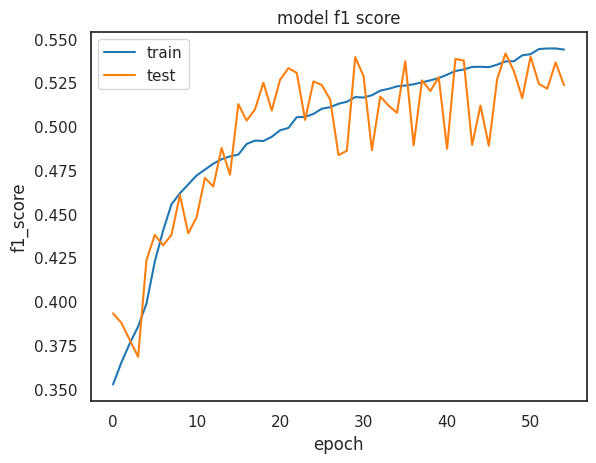

In [54]:
# summarize history for f1 score
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1 score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

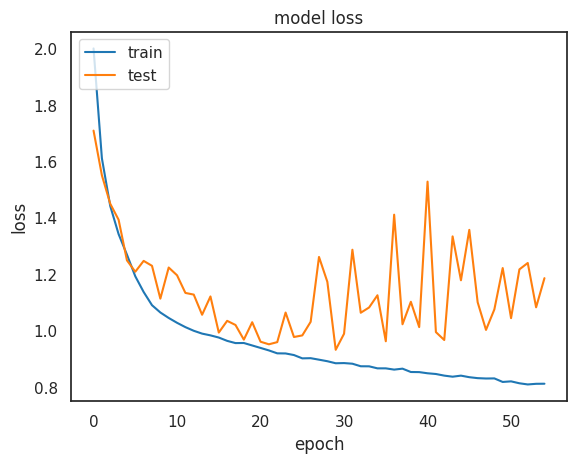

In [55]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

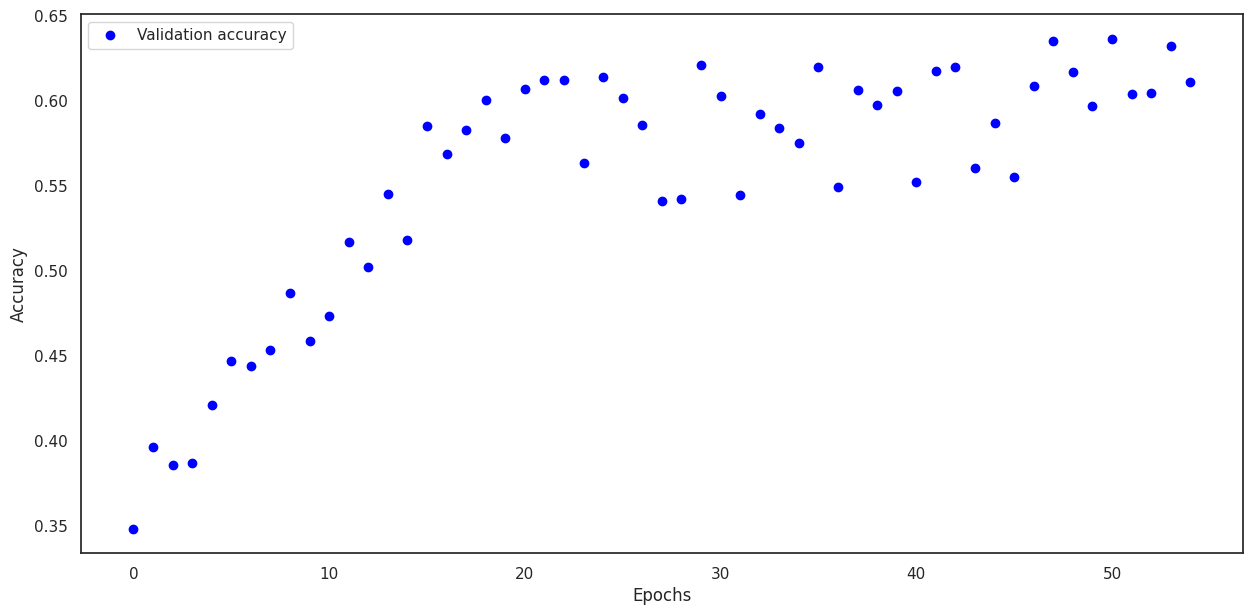

In [56]:
history_dict = history.history
Accuracy = history_dict['val_binary_accuracy']
plt.figure(num=1, figsize=(15,7))
plt.plot(Accuracy,'bo',label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
import gc
gc.collect()

1237

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [11]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]

def model_5():
    model_5 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ])
    
    model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_5

model_5 = model_5()
model_5.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 1022, 126, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1022, 126, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 511, 63, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 509, 61, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 509, 61, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 254, 30, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 252, 28, 128)   │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 252, 28, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 126, 14, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 124, 12, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 124, 12, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │        32,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,707,784 (40.85 MB)

 Trainable params: 10,707,304 (40.85 MB)

 Non-trainable params: 480 (1.88 KB)

In [12]:
history = model_5.fit(
    train_ds,
    epochs=250,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 206ms/step - accuracy: 0.3518 - loss: 1.7157 - val_accuracy: 0.0701 - val_loss: 2.7655 - learning_rate: 1.0000e-04
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.4525 - loss: 1.4206 - val_accuracy: 0.0701 - val_loss: 5.9857 - learning_rate: 1.0000e-04
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5219 - loss: 1.2577 - val_accuracy: 0.1240 - val_loss: 6.5224 - learning_rate: 1.0000e-04
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5501 - loss: 1.1867 - val_accuracy: 0.2480 - val_loss: 5.8732 - learning_rate: 1.0000e-04
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.5775 - loss: 1.1322 - val_accuracy: 0.1914 - val_loss: 5.4014 - learning_rate: 1.0000e-04
Epoch 6/500
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6154 - loss: 0.9994
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - 

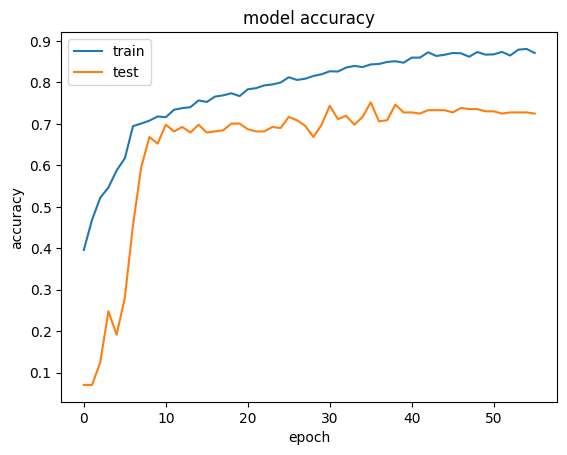

In [13]:
# summarize history for accuracy
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

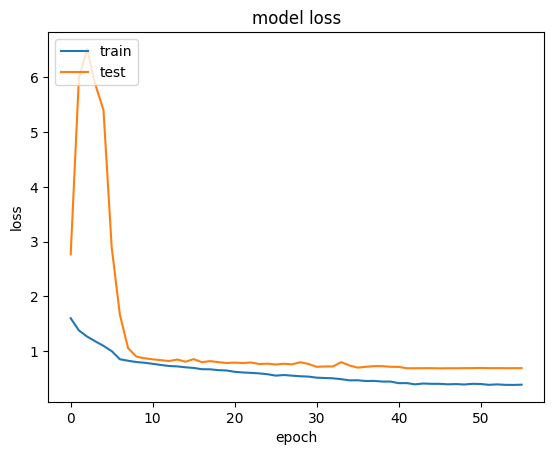

In [14]:
# summarize history for loss
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

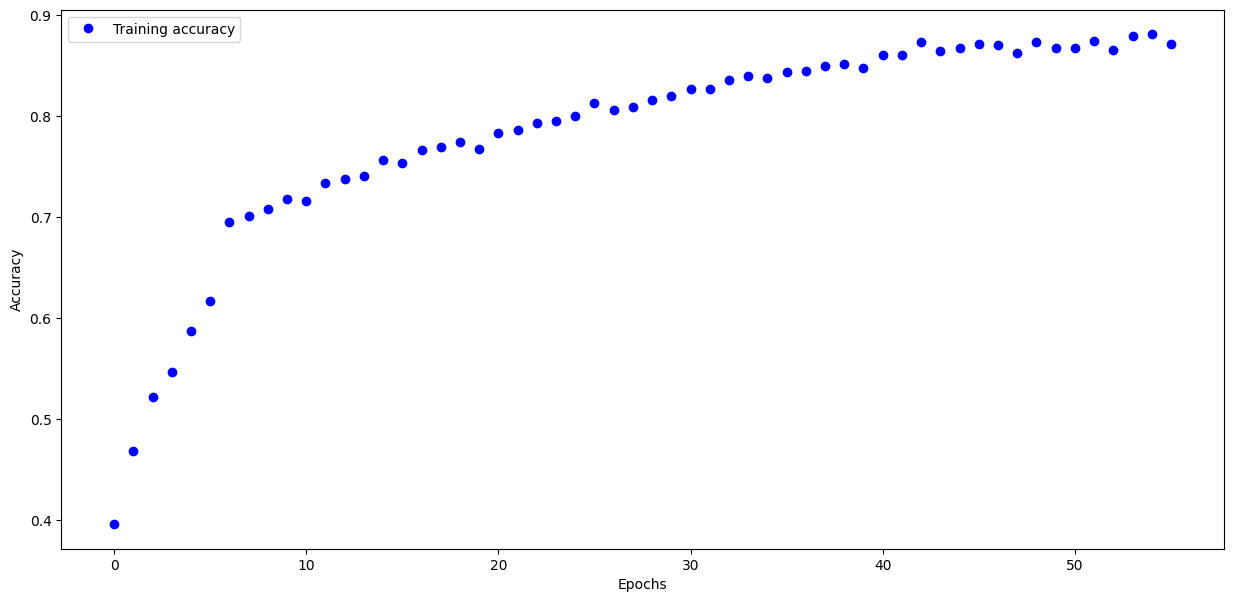

In [15]:
history_dict = history_5.history
Accuracy = history_dict['accuracy']
plt.figure(num=1, figsize=(15,7))
plt.plot(Accuracy,'bo',label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
import gc
gc.collect()

22

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [8]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]

def model_6():
    model_6 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ])
    
    model_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_6

model_6 = model_6()
model_6.summary()

/home/georgios/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1739745018.417788  257136 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1022, 126, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1022, 126, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 511, 63, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 509, 61, 128)   │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 509, 61, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 254, 30, 128)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 252, 28, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 252, 28, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │        32,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,734,184 (44.76 MB)

 Trainable params: 11,733,768 (44.76 MB)

 Non-trainable params: 416 (1.62 KB)

In [9]:
callbacks = [
    lr_scheduler,
    early_stopping,
    tf.keras.callbacks.ModelCheckpoint('best_model_6.keras', save_best_only=True, monitor='val_accuracy')
]

history_6 = model_6.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks
)
#had 70% previous run with training acc arround 85% with dropout @0.5
#76% with train acc ~83% with dropout @0.1
test_loss, test_acc = model_6.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/500


I0000 00:00:1739745021.627145  257311 service.cc:148] XLA service 0x7f2f6c016cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739745021.627174  257311 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1739745021.873706  257311 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/105 ━━━━━━━━━━━━━━━━━━━━ 31:40 18s/step - accuracy: 0.0938 - loss: 2.0750

I0000 00:00:1739745038.254897  257311 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 259ms/step - accuracy: 0.3351 - loss: 1.7788 - val_accuracy: 0.2884 - val_loss: 1.8150 - learning_rate: 1.0000e-04
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.4323 - loss: 1.5034 - val_accuracy: 0.3989 - val_loss: 2.0751 - learning_rate: 1.0000e-04
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.4769 - loss: 1.3531 - val_accuracy: 0.3235 - val_loss: 1.9058 - learning_rate: 1.0000e-04
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.4943 - loss: 1.3293 - val_accuracy: 0.3801 - val_loss: 1.8876 - learning_rate: 1.0000e-04
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.5259 - loss: 1.2108 - val_accuracy: 0.4259 - val_loss: 1.6603 - learning_rate: 1.0000e-04
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.5624 - loss: 1.1437 - val_accuracy: 0.4340 - val_loss: 1.4937 - learning_rate: 1.0000e-04
Epoch 7/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step 

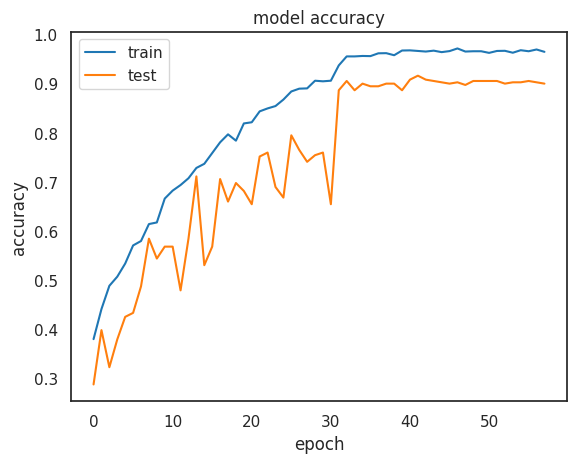

In [10]:
# summarize history for accuracy
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

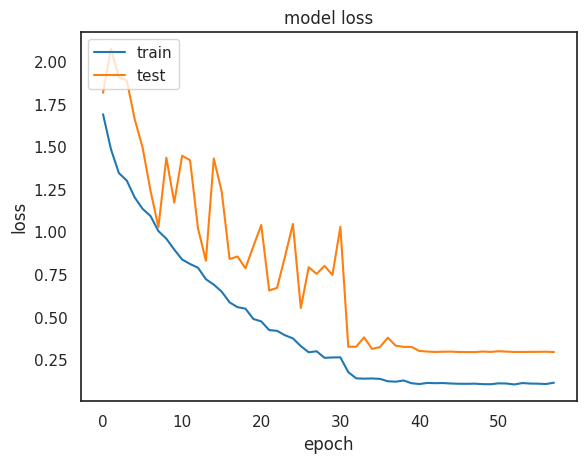

In [11]:
# summarize history for loss
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

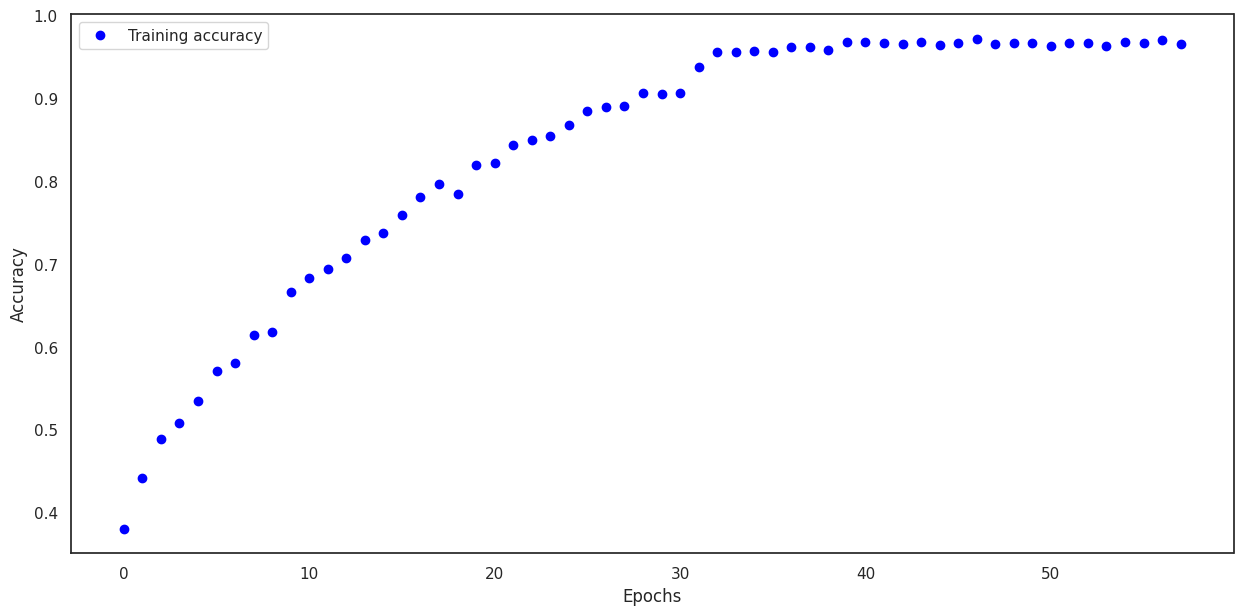

In [12]:
history_dict = history_6.history
Accuracy = history_dict['accuracy']
plt.figure(num=1, figsize=(15,7))
plt.plot(Accuracy,'bo',label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
import gc
gc.collect()

7522

In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [15]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]

def model_7():
    model_7 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ])
    
    model_7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_7

model_7 = model_7()
model_7.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 1022, 126, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1022, 126, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 511, 63, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 509, 61, 128)   │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 509, 61, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 254, 30, 128)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 252, 28, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 252, 28, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │        32,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,734,184 (44.76 MB)

 Trainable params: 11,733,768 (44.76 MB)

 Non-trainable params: 416 (1.62 KB)

In [16]:
callbacks = [
    lr_scheduler,
    early_stopping,
    tf.keras.callbacks.ModelCheckpoint('best_model_7.keras', save_best_only=True, monitor='val_accuracy')
]

history_7 = model_7.fit(
    X_train, y_train,
    epochs=250,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks
)
#had 70% previous run with training acc arround 85% with dropout @0.5
#76% with train acc ~83% with dropout @0.1
test_loss, test_acc = model_7.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.3336 - loss: 1.7903 - val_accuracy: 0.2830 - val_loss: 1.8246 - learning_rate: 1.0000e-04
Epoch 2/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.4151 - loss: 1.5396 - val_accuracy: 0.3989 - val_loss: 1.9000 - learning_rate: 1.0000e-04
Epoch 3/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.4814 - loss: 1.3840 - val_accuracy: 0.3235 - val_loss: 1.8286 - learning_rate: 1.0000e-04
Epoch 4/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.4922 - loss: 1.3103 - val_accuracy: 0.3908 - val_loss: 2.1314 - learning_rate: 1.0000e-04
Epoch 5/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.5200 - loss: 1.2308 - val_accuracy: 0.4367 - val_loss: 1.6436 - learning_rate: 1.0000e-04
Epoch 6/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.5487 - loss: 1.1463 - val_accuracy: 0.5121 - val_loss: 1.2929 - learning_rate: 1.0000e-04
Epoch 7/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 11

In [ ]:
# Evaluate the model 80% acc, 82% test acc, loss 0.61
loss, acc = model_best.evaluate(X_test, y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
# Loads the weights
model_best.load_weights('best_model.h5')

# Re-evaluate the model
loss, acc = model_best.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [17]:
gc.collect()

1069

In [18]:
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)